In [1]:
# import libraries
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('Final_Invoice.csv')

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
data.head()

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total Amt Wtd Tax.,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2
2,2,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE[W],NaN,NaN,Retail,81055,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200004,11:12:57,173889,2015-01-02,11:40:44,33985,180.19,MARUTI SUZUKI,0.00,ZEN,7.005200e+09,0.00,Running Repairs,0.0,52.95,400607,BC01,THANE,NaN,NO,0.0,AP09AX0582,0.0,0.0,0.0,0.0,NaN,0.0,IMRAN,233.14,0.0,0.0,0.0,0.0,233.14,BC01SA2
3,3,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200005,11:40:44,174158,2015-01-03,10:12:32,78584,0.00,TATA MOTORS,0.00,INDICA,7.005200e+09,0.00,SMC Redemption,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,0.00,0.0,0.0,0.0,0.0,0.00,BC01SA2
4,4,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE,NaN,NaN,Retail,18980,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200006,12:07:17,173860,2015-01-02,10:45:42,50057,1202.97,HYUNDAI,100.00,SANTRO XING,7.005200e+09,499.99,Paid Service,0.0,944.16,400603,BC01,THANE,NaN,NO,0.0,MH04CD9768,0.0,0.0,0.0,0.0,NaN,0.0,DAYANAND,2747.12,0.0,0.0,0.0,0.0,2747.12,BC01SA2


In [5]:
data['Invoice_DateTime'] = pd.to_datetime(data['Invoice Date'] + ' ' + data['Invoice Time'])

In [6]:
data['JobCard_DateTime'] = pd.to_datetime(data['JobCard Date'] + ' ' + data['JobCard Time'])

In [7]:
data['Service Time']=data['Invoice_DateTime'].sub(data['JobCard_DateTime'], axis=0)

In [8]:
data['Service Hour'] = data['Service Time'].apply(lambda x : (x.days * 24 + x.seconds//3600))

# Clustering based on Customers

In [9]:
df_clus =data.groupby(['Customer No.','Make','Order Type'])['Service Hour','Total Amt Wtd Tax.'].sum().reset_index()
df_clus.head()

,Customer No.,Make,Order Type,Service Hour,Total Amt Wtd Tax.
0,1,MARUTI SUZUKI,Paid Service,6248,0.00
1,1,MARUTI SUZUKI,Running Repairs,321,0.00
2,10,GENERAL MOTORS,Paid Service,87,10505.72
3,10,GENERAL MOTORS,Running Repairs,3,599.84
4,100,HONDA,Accidental,98,14167.07


In [10]:
#One-hot Encoding 'Make'
make = pd.get_dummies(df_clus['Make'], prefix='make')
df_clus= pd.concat([df_clus, make], axis=1)
df_clus.drop(['Make'],1,inplace=True)
df_clus.head()

,Customer No.,Order Type,Service Hour,Total Amt Wtd Tax.,make_AUDI,make_BMW,make_DAEWOO,make_FIAT,make_FORCE,make_FORD,make_GENERAL MOTORS,make_HINDUSTAN MOTORS,make_HONDA,make_HYUNDAI,make_JEEP,make_LAND ROVER,make_MAHINDRA & MAHINDRA,make_MARUTI SUZUKI,make_MERCEDES BENZ,make_MITSUBISHI MOTORS,make_MORRIS,make_NISSAN,make_PORCHE,make_PREMIER AUTOMOBILES,make_RENAULT,make_SAN MOTORS,make_SKODA,make_SONALIKA,make_TATA MOTORS,make_TOYOTA,make_VOLKSWAGEN,make_VOLVO
0,1,Paid Service,6248,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Running Repairs,321,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10,Paid Service,87,10505.72,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,Running Repairs,3,599.84,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100,Accidental,98,14167.07,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
#One- hot encoding 'Order Type'
order = pd.get_dummies(df_clus['Order Type'], prefix='order')
df_clus= pd.concat([df_clus, order], axis=1)
df_clus.drop(['Order Type'],1,inplace=True)
df_clus.head()

,Customer No.,Service Hour,Total Amt Wtd Tax.,make_AUDI,make_BMW,make_DAEWOO,make_FIAT,make_FORCE,make_FORD,make_GENERAL MOTORS,make_HINDUSTAN MOTORS,make_HONDA,make_HYUNDAI,make_JEEP,make_LAND ROVER,make_MAHINDRA & MAHINDRA,make_MARUTI SUZUKI,make_MERCEDES BENZ,make_MITSUBISHI MOTORS,make_MORRIS,make_NISSAN,make_PORCHE,make_PREMIER AUTOMOBILES,make_RENAULT,make_SAN MOTORS,make_SKODA,make_SONALIKA,make_TATA MOTORS,make_TOYOTA,make_VOLKSWAGEN,make_VOLVO,order_Accidental,order_Mechanical,order_Paid Service,order_Repeat Order,order_Running Repairs,order_SMC Redemption,order_SMC Value Package,order_WBW Order,order_Workshop Damage
0,1,6248,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,321,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,10,87,10505.72,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,10,3,599.84,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,100,98,14167.07,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [12]:
#Drop Customer No
df_clus1 = df_clus.drop(['Customer No.'],1)
df_clus1.head()

,Service Hour,Total Amt Wtd Tax.,make_AUDI,make_BMW,make_DAEWOO,make_FIAT,make_FORCE,make_FORD,make_GENERAL MOTORS,make_HINDUSTAN MOTORS,make_HONDA,make_HYUNDAI,make_JEEP,make_LAND ROVER,make_MAHINDRA & MAHINDRA,make_MARUTI SUZUKI,make_MERCEDES BENZ,make_MITSUBISHI MOTORS,make_MORRIS,make_NISSAN,make_PORCHE,make_PREMIER AUTOMOBILES,make_RENAULT,make_SAN MOTORS,make_SKODA,make_SONALIKA,make_TATA MOTORS,make_TOYOTA,make_VOLKSWAGEN,make_VOLVO,order_Accidental,order_Mechanical,order_Paid Service,order_Repeat Order,order_Running Repairs,order_SMC Redemption,order_SMC Value Package,order_WBW Order,order_Workshop Damage
0,6248,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,321,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,87,10505.72,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,599.84,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,98,14167.07,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


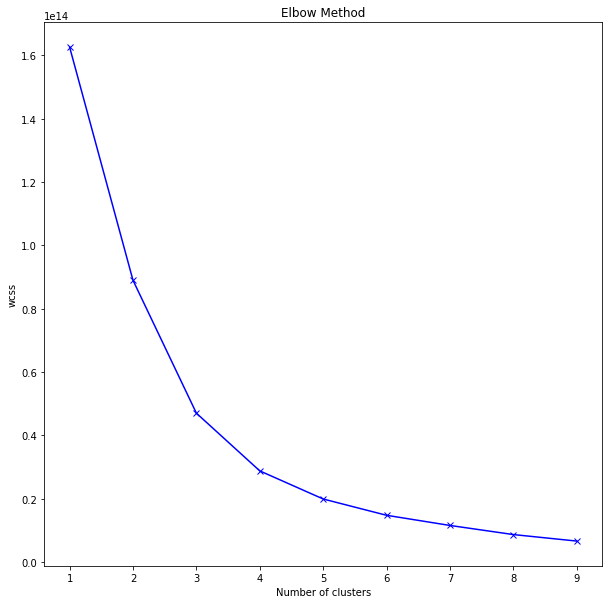

In [13]:
#K-Means Clustering for Customer
# Empty list for storing WCSS across all values of k
dist = []
# Iterate from 1-9
for i in range(1,10):
    # Initialize KMeans algorithm
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit on data
    km.fit(df_clus1)
    # Append WCSS to list storing WCSS
    dist.append(km.inertia_)
# Initialize figure
plt.figure(figsize=(10,10))
# Line plot # clusters on X-axis and WCSS on Y-axis 
plt.plot(range(1,10),dist,'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [14]:
# Clustering to find 4 clusters(optimum no.) for Customers

km = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)

df_clus['clusters'] = km.fit_predict(df_clus1)
# Cluster centers
centroids_1 = km.cluster_centers_
print("Cluster centers are:", centroids_1)
print('='*20)
# Within cluster sum of squares
wcss_1 = km.inertia_
print("Within cluster sum of squares is:", wcss_1)

Cluster centers are: [[ 9.28331302e+01  3.60401554e+03  4.25957939e-04  5.06796672e-04
   8.17714876e-04  1.29124330e-02  4.72595670e-04  4.42996257e-02
   5.79022971e-02  4.88141580e-04  3.29542204e-02  1.77189175e-01
   1.86550922e-05  5.59652767e-05  1.52306391e-01  3.19944159e-01
   5.93853769e-04  2.88843011e-03  6.21836407e-06  6.88061985e-03
   1.55459102e-05  1.95878468e-04  7.45892771e-03  2.17642743e-05
   1.30212544e-02  1.92769286e-04  1.16264753e-01  3.91725845e-02
   1.29373065e-02  5.59652767e-05  8.39883343e-02  4.15106894e-02
   2.98736428e-01  8.64352606e-03  5.11500864e-01  2.72239979e-02
   2.82997749e-02  4.35285485e-05  5.28560946e-05]
 [ 6.41133333e+04  4.96294219e+06  0.00000000e+00  0.00000000e+00
   1.08420217e-19  0.00000000e+00  5.42101086e-20  0.00000000e+00
   0.00000000e+00  5.42101086e-20  0.00000000e+00  2.77555756e-17
   0.00000000e+00  6.77626358e-21  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  8.67361738e-19
   1

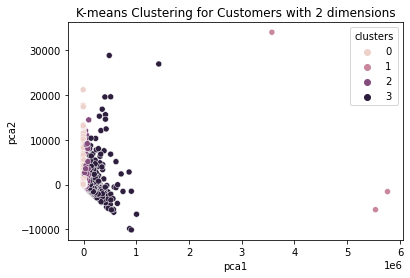

In [15]:
#Plotting the Customer Clusters

reduced_data = PCA(n_components=2).fit_transform(df_clus1)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_clus['clusters'], data=results)
plt.title('K-means Clustering for Customers with 2 dimensions')
plt.show()

In [16]:
df_clus.groupby('clusters')['Total Amt Wtd Tax.'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,321621.0,3.603632e+03,4.463738e+03,-0.01,3.663300e+02,1886.890,5033.69,21219.99
1,3.0,4.962942e+06,1.205391e+06,3577327.32,4.559481e+06,5541635.400,5655749.63,5769863.86
2,20071.0,3.882984e+04,1.874419e+04,21214.68,2.536918e+04,31958.970,45388.32,112683.77
3,1128.0,1.865835e+05,1.045227e+05,112792.53,1.285768e+05,153112.445,204594.22,1432999.79


In [17]:
#Low Revenue Earning Cluster of Customer
low_rev_customer = df_clus[df_clus['clusters']==0]
#Top 5 Low Revenue Earning customer Numbers
low_rev_customer['Customer No.'].value_counts().head()

45869      18
MFM15      18
E11111     17
MFCCM14    16
MFCWP01    15
Name: Customer No., dtype: int64

In [18]:
#Medium Revenue Earning Cluster of Customer
medium_rev_customer = df_clus[df_clus['clusters']==2]
#Top 5 Medium Revenue Earning customer Numbers
medium_rev_customer['Customer No.'].value_counts().head()

E1205      16
MFCWP01    14
148721     10
E11111      9
MFM15       7
Name: Customer No., dtype: int64

In [19]:
#High Revenue Earning Cluster of Customer
high_rev_customer = df_clus[df_clus['clusters']==1]
#Top 5 High Revenue Earning customer Numbers
high_rev_customer['Customer No.'].value_counts().head()

E4981    2
412      1
Name: Customer No., dtype: int64

In [20]:
#Very High Revenue Earning Cluster of Customer
vhigh_rev_customer = df_clus[df_clus['clusters']==3]
#Top 5 Very High Revenue Earning customer Numbers
vhigh_rev_customer['Customer No.'].value_counts().head()

MFCCM14    6
E1205      5
E11206     4
MFCCM03    3
153695     3
Name: Customer No., dtype: int64

# Clustering for Revenue generated from different Car Models

In [21]:
df_make = data[['Make', 'Model','KMs Reading','Order Type','Service Hour', 'Total Amt Wtd Tax.']]
df_make.head()

,Make,Model,KMs Reading,Order Type,Service Hour,Total Amt Wtd Tax.
0,GENERAL MOTORS,SPARK,49317,Paid Service,477,4051.95
1,TATA MOTORS,INDICA,78584,SMC Value Package,19,1001.29
2,MARUTI SUZUKI,ZEN,33985,Running Repairs,23,233.14
3,TATA MOTORS,INDICA,78584,SMC Redemption,1,0.00
4,HYUNDAI,SANTRO XING,50057,Paid Service,25,2747.12


In [22]:
#Binning The KM Reading assuming Car driven in 1 yr = 25000kms
df_make['Car_Age'] = 1
df_make.loc[df_make['KMs Reading']>25000,'Car_Age'] = 2
df_make.loc[df_make['KMs Reading']>50000,'Car_Age'] = 3
df_make.loc[df_make['KMs Reading']>75000,'Car_Age'] = 4
df_make.loc[df_make['KMs Reading']>100000,'Car_Age'] = 5
df_make.loc[df_make['KMs Reading']>150000,'Car_Age'] = 6
df_make.loc[df_make['KMs Reading']>175000,'Car_Age'] = 7
df_make.loc[df_make['KMs Reading']>200000,'Car_Age'] = 8
df_make.loc[df_make['KMs Reading']>250000,'Car_Age'] = 9
df_make.loc[df_make['KMs Reading']>275000,'Car_Age'] = 10


In [23]:
#Concatenate Make and Model
df_make['Car_Model'] = df_make['Make'] + ' - ' + df_make['Model']

In [24]:
df_make.head()

,Make,Model,KMs Reading,Order Type,Service Hour,Total Amt Wtd Tax.,Car_Age,Car_Model
0,GENERAL MOTORS,SPARK,49317,Paid Service,477,4051.95,2,GENERAL MOTORS - SPARK
1,TATA MOTORS,INDICA,78584,SMC Value Package,19,1001.29,4,TATA MOTORS - INDICA
2,MARUTI SUZUKI,ZEN,33985,Running Repairs,23,233.14,2,MARUTI SUZUKI - ZEN
3,TATA MOTORS,INDICA,78584,SMC Redemption,1,0.00,4,TATA MOTORS - INDICA
4,HYUNDAI,SANTRO XING,50057,Paid Service,25,2747.12,3,HYUNDAI - SANTRO XING


In [25]:
#Groupby
df_make1 = df_make.groupby(['Car_Model', 'Car_Age', 'Order Type'])['Service Hour','Total Amt Wtd Tax.'].sum().reset_index()
df_make1.head()

,Car_Model,Car_Age,Order Type,Service Hour,Total Amt Wtd Tax.
0,AUDI - A4,1,Accidental,279,68415.01
1,AUDI - A4,1,Mechanical,1,386.96
2,AUDI - A4,1,Paid Service,7,904.26
3,AUDI - A4,1,Running Repairs,61,11095.05
4,AUDI - A4,2,Accidental,606,161547.51


In [26]:
#One- hot encoding for Order Type
order = pd.get_dummies(df_make1['Order Type'], prefix='order')
df_make1= pd.concat([df_make1, order], axis=1)
df_make1.drop(['Order Type'],1,inplace=True)
df_make1.head()

,Car_Model,Car_Age,Service Hour,Total Amt Wtd Tax.,order_Accidental,order_Mechanical,order_Paid Service,order_Repeat Order,order_Running Repairs,order_SMC Redemption,order_SMC Value Package,order_WBW Order,order_Workshop Damage
0,AUDI - A4,1,279,68415.01,1,0,0,0,0,0,0,0,0
1,AUDI - A4,1,1,386.96,0,1,0,0,0,0,0,0,0
2,AUDI - A4,1,7,904.26,0,0,1,0,0,0,0,0,0
3,AUDI - A4,1,61,11095.05,0,0,0,0,1,0,0,0,0
4,AUDI - A4,2,606,161547.51,1,0,0,0,0,0,0,0,0


In [27]:
df_make2 = df_make1.drop('Car_Model',1)
df_make2.head()

,Car_Age,Service Hour,Total Amt Wtd Tax.,order_Accidental,order_Mechanical,order_Paid Service,order_Repeat Order,order_Running Repairs,order_SMC Redemption,order_SMC Value Package,order_WBW Order,order_Workshop Damage
0,1,279,68415.01,1,0,0,0,0,0,0,0,0
1,1,1,386.96,0,1,0,0,0,0,0,0,0
2,1,7,904.26,0,0,1,0,0,0,0,0,0
3,1,61,11095.05,0,0,0,0,1,0,0,0,0
4,2,606,161547.51,1,0,0,0,0,0,0,0,0


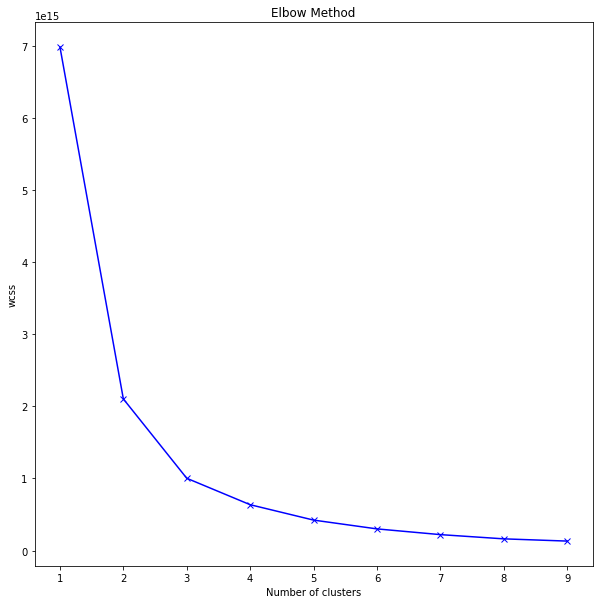

In [28]:
#K-Means Clustering for Car Models

# Empty list for storing WCSS across all values of k
dist = []

# Iterate from 1-9
for i in range(1,10):
    # Initialize KMeans algorithm
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit on data
    km.fit(df_make2)
    # Append WCSS to list storing WCSS
    dist.append(km.inertia_)

# Initialize figure
plt.figure(figsize=(10,10))

# Line plot # clusters on X-axis and WCSS on Y-axis 
plt.plot(range(1,10),dist,'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [29]:
#Clustering for making 4 clusters
km = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
#km.fit(df_hr_amt)
df_make1['clusters'] = km.fit_predict(df_make2)
# Cluster centers
centroids_1 = km.cluster_centers_
print("Cluster centers are:", centroids_1)
print('='*20)

# Within cluster sum of squares
wcss_1 = km.inertia_
print("Within cluster sum of squares is:", wcss_1)

Cluster centers are: [[ 4.57525376e+00  1.78285999e+03  7.13308351e+04  1.45432272e-01
   1.56457823e-01  2.05810291e-01  7.63038152e-02  2.34161708e-01
   8.97794890e-02  8.68043402e-02  2.80014001e-03  2.45012251e-03]
 [ 3.10606061e+00  1.24791970e+05  7.82138496e+06  3.78787879e-01
   5.55111512e-17  3.18181818e-01 -4.16333634e-17  3.03030303e-01
   2.77555756e-17  2.77555756e-17  8.67361738e-19  8.67361738e-19]
 [ 3.44318182e+00  6.29826989e+04  3.58433110e+06  3.80681818e-01
   8.32667268e-17  2.95454545e-01 -8.32667268e-17  3.23863636e-01
  -1.38777878e-17  6.93889390e-17  1.30104261e-18  1.30104261e-18]
 [ 3.62295082e+00  2.29552684e+04  1.23432843e+06  3.58606557e-01
   4.09836066e-03  2.90983607e-01 -1.66533454e-16  3.29918033e-01
   4.16333634e-17  1.63934426e-02  2.16840434e-18 -1.73472348e-18]]
Within cluster sum of squares is: 635245612812558.4


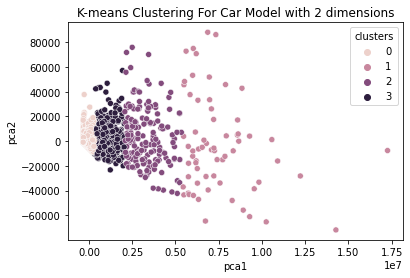

In [30]:
#plotting Model Segmentation 
reduced_data = PCA(n_components=2).fit_transform(df_make2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_make1['clusters'], data=results)
plt.title('K-means Clustering For Car Model with 2 dimensions')
plt.show()

In [31]:
df_make1.groupby('clusters')['Total Amt Wtd Tax.'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,5714.0,7.133084e+04,1.282274e+05,0.00,1.387455e+03,13402.275,7.375389e+04,652171.63
1,66.0,7.821385e+06,2.115900e+06,5780545.63,6.399180e+06,7257517.185,8.656287e+06,17592327.45
2,176.0,3.584331e+06,8.846034e+05,2408978.58,2.841226e+06,3421793.500,4.161356e+06,5674590.13
3,488.0,1.234328e+06,4.816313e+05,653780.00,8.295703e+05,1102231.590,1.558122e+06,2397987.62


In [32]:
#Low Revenue Earning Cluster of Car Models
low_rev_model = df_make1[df_make1['clusters']==2]
#Top 5 Low Revenue Earning Models
low_rev_model['Car_Model'].value_counts().head()

TATA MOTORS - VISTA     12
HYUNDAI - VERNA         11
TATA MOTORS - INDIGO    11
HONDA - CITY            10
TATA MOTORS - INDICA    10
Name: Car_Model, dtype: int64

In [33]:
#Medium Revenue Earning Cluster of Car Models
medium_rev_model = df_make1[df_make1['clusters']==0]
#Top 5 Medium Revenue Earning Models
medium_rev_model['Car_Model'].value_counts().head()

TATA MOTORS - SUMO         52
HYUNDAI - SANTRO           52
MARUTI SUZUKI - EECO       52
GENERAL MOTORS - TAVERA    51
TATA MOTORS - VISTA        51
Name: Car_Model, dtype: int64

In [34]:
#High Revenue Earning Cluster of Car Models
high_rev_model = df_make1[df_make1['clusters']==3]
#Top 5 High Revenue Earning Models
high_rev_model['Car_Model'].value_counts().head()

TOYOTA - INNOVA                         16
MAHINDRA &  MAHINDRA - LOGAN D          16
MARUTI SUZUKI - RITZ                    15
MAHINDRA &  MAHINDRA - BOLERO PIK UP    13
MAHINDRA &  MAHINDRA - BOLERO           13
Name: Car_Model, dtype: int64

In [35]:
#Very High Revenue Earning Cluster of Car Models
vhigh_rev_model = df_make1[df_make1['clusters']==1]
#Top 5 Very High Revenue Earning Models
vhigh_rev_model['Car_Model'].value_counts().head(10)

MARUTI SUZUKI - SWIFT                  13
MAHINDRA &  MAHINDRA - SCORPIO CRDE    12
MAHINDRA &  MAHINDRA - XYLO             6
HYUNDAI - SANTRO                        6
MARUTI SUZUKI - ALTO                    6
MAHINDRA &  MAHINDRA - BOLERO           5
HYUNDAI - I10                           4
MARUTI SUZUKI - WAGONR                  4
TATA MOTORS - INDICA                    3
MARUTI SUZUKI - SWIFT DZIRE             3
Name: Car_Model, dtype: int64

# THE END